In [49]:
"""
================================================================
Visualizing learned state sequences and transition probabilities
================================================================

Train a sticky HDP-HMM model on small motion capture data, then visualize the MAP state sequences under the estimated model parameters by running Viterbi.

Also has some info on how to inspect the learned HMM parameters of a sticky HDP-HMM model trained on small motion capture data.

"""
# sphinx_gallery_thumbnail_number = 3

import matplotlib.pyplot
import bnpy
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns

np.set_printoptions(suppress=1, precision=3)

FIG_SIZE = (10, 5)
pylab.rcParams['figure.figsize'] = FIG_SIZE

In [42]:
###############################################################################
#
# Load dataset from file

dataset_path = os.path.join(bnpy.DATASET_PATH, 'mocap6')
dataset = bnpy.data.GroupXData.read_npz(
    os.path.join(dataset_path, 'dataset.npz'))

In [43]:
###############################################################################
#
# Setup: Function to make a simple plot of the raw data
# -----------------------------------------------------

def show_single_sequence(
        seq_id,
        zhat_T=None,
        z_img_cmap=None,
        ylim=[-120, 120],
        K=5,
        left=0.2, bottom=0.2, right=0.8, top=0.95):
    if z_img_cmap is None:
        z_img_cmap = matplotlib.pyplot.get_cmap('Set1', K)

    if zhat_T is None:
        nrows = 1
    else:
        nrows = 2
    fig_h, ax_handles = pylab.subplots(
        nrows=nrows, ncols=1, sharex=True, sharey=False)
    ax_handles = np.atleast_1d(ax_handles).flatten().tolist()

    start = dataset.doc_range[seq_id]
    stop = dataset.doc_range[seq_id + 1]
    # Extract current sequence
    # as a 2D array : T x D (n_timesteps x n_dims)
    curX_TD = dataset.X[start:stop]
    for dim in range(12):
        ax_handles[0].plot(curX_TD[:, dim], '.-')
    ax_handles[0].set_ylabel('angle')
    ax_handles[0].set_ylim(ylim)
    z_img_height = int(np.ceil(ylim[1] - ylim[0]))
    pylab.subplots_adjust(
        wspace=0.1,
        hspace=0.1,
        left=left, right=right,
        bottom=bottom, top=top)
    if zhat_T is not None:
        img_TD = np.tile(zhat_T, (z_img_height, 1))
        ax_handles[1].imshow(
            img_TD,
            interpolation='nearest',
            vmin=-0.5, vmax=(K-1)+0.5,
            cmap=z_img_cmap)
        ax_handles[1].set_ylim(0, z_img_height)
        ax_handles[1].set_yticks([])

        bbox = ax_handles[1].get_position()
        width = (1.0 - bbox.x1) / 3
        height = bbox.y1 - bbox.y0
        cax = fig_h.add_axes([right + 0.01, bottom, width, height])
        cbax_h = fig_h.colorbar(
            ax_handles[1].images[0], cax=cax, orientation='vertical')
        cbax_h.set_ticks(np.arange(K))
        cbax_h.set_ticklabels(np.arange(K))
        cbax_h.ax.tick_params(labelsize=9)

    ax_handles[-1].set_xlabel('time')
    return ax_handles

In [48]:
print(dataset.X.shape)
print(dataset.Xprev.shape)

(2058, 12)
(2058, 12)


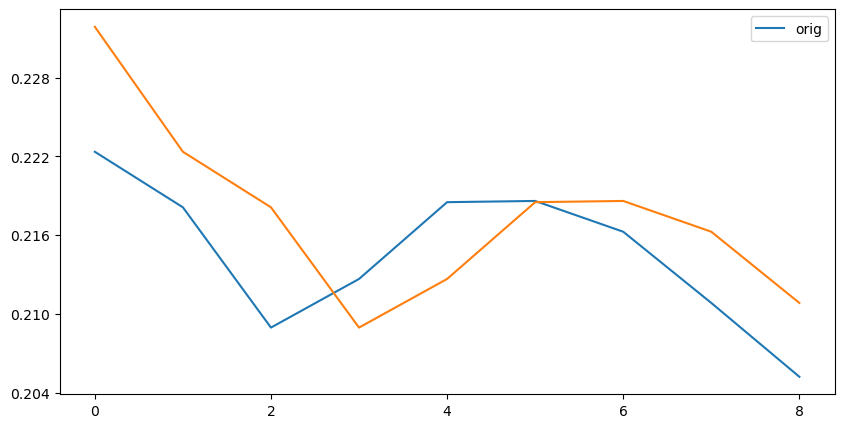

In [57]:
plt.plot(dataset.X[-10:-1, :1], label = "orig")
plt.plot(dataset.Xprev[-10:-1, :1])
plt.legend()

[<Axes: xlabel='time', ylabel='angle'>]

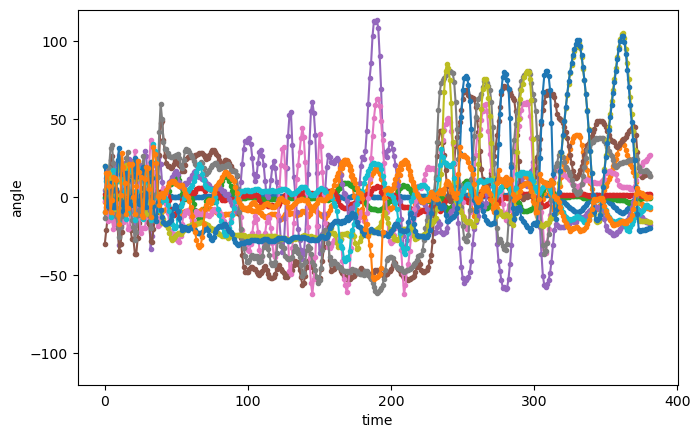

In [4]:
###############################################################################
#
# Visualization of the first sequence (1 of 6)
# --------------------------------------------

show_single_sequence(0)


In [4]:
###############################################################################
#
# Setup: hyperparameters
# ----------------------------------------------------------

K = 5            # Number of clusters/states

# Allocation model (HDP)
gamma      =   5.0  # top-level Dirichlet concentration parameter
transAlpha =   0.5  # trans-level Dirichlet concentration parameter 
startAlpha =  10.0  # starting-state Dirichlet concentration parameter
hmmKappa   =  50.0  # set sticky self-transition weight

# Observation model (1st-order Auto-regressive Gaussian)
sF = 1.0          # Set observation model prior so E[covariance] = identity
ECovMat = 'eye'

In [6]:
###############################################################################
#
# Train HDP-HMM with *AutoRegGauss* observation model
# ----------------------------------------------
#
# Train single model for all 6 sequences.
#
# Do small number of clusters jut to make visualization easy.
#
# Take the best of 5 random initializations (in terms of evidence lower bound).
#

hdphmm_trained_model, hmmar_info_dict = bnpy.run(
    dataset, 'HDPHMM', 'AutoRegGauss', 'memoVB',
    output_path=(
        '/tmp/mocap6/showcase-K=%d-model=HDPHMM+AutoRegGauss-ECovMat=1*eye/'
        % (K)),
    nLap=100, nTask=5, nBatch=1, convergeThr=0.0001,
    transAlpha=transAlpha, startAlpha=startAlpha, hmmKappa=hmmKappa,
    gamma=gamma,
    sF=sF, ECovMat=ECovMat,
    K=K, initname='randexamples',
    printEvery=25,
    )

Dataset Summary:
GroupXData
  total size: 6 units
  batch size: 6 units
  num. batches: 1
Allocation Model:  None
Obs. Data  Model:  Auto-Regressive Gaussian with full covariance.
Obs. Data  Prior:  MatrixNormal-Wishart on each mean/prec matrix pair: A, Lam
  E[ A ] = 
  [[1. 0.]
   [0. 1.]] ...
  E[ Sigma ] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 5 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/5 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/showcase-K=5-model=HDPHMM+AutoRegGauss-ECovMat=1*eye/1
    1.000/100 after      0 sec. |    185.2 MiB | K    5 | loss  2.772882295e+00 |  
    2.000/100 after      0 sec. |    185.2 MiB | K    5 | loss  2.502603548e+00 | Ndiff  470.393 
    3.000/100 after      0 sec. |    185.2 MiB | K    5 | loss  2.426864576e+00 | Ndiff  119.274 
   25.000/100 after      3 sec. |    185.5 MiB | K    5 | loss  2.302556401e+00 | Ndiff   18.913 
   50.0

In [7]:
###############################################################################
# 
# Visualize the starting-state probabilities
# ------------------------------------------
# 
# start_prob_K : 1D array, size K
#     start_prob_K[k] = exp( E[log Pr(start state = k)] )

start_prob_K = hdphmm_trained_model.allocModel.get_init_prob_vector()

print(start_prob_K)

[0.249 0.336 0.032 0.025 0.168]


In [8]:
###############################################################################
# 
# Visualize the transition probabilities
# --------------------------------------
# 
# trans_prob_KK : 2D array, K x K
#     trans_prob_KK[j, k] = exp( E[log Pr(z_t = k | z_t-1 = j)] )
#

trans_prob_KK = hdphmm_trained_model.allocModel.get_trans_prob_matrix()

print(trans_prob_KK)

[[0.917 0.008 0.052 0.009 0.011]
 [0.025 0.953 0.    0.    0.019]
 [0.09  0.011 0.861 0.035 0.   ]
 [0.012 0.    0.077 0.907 0.   ]
 [0.021 0.026 0.    0.    0.95 ]]


In [9]:
###############################################################################
# 
# Compute log likelihood of each timestep for sequence 0
# ------------------------------------------------------
#
# log_lik_TK : 2D array, T x K
#     log_lik_TK[t, k] = E[ log Pr( observed data at time t | z_t = k)]

log_lik_seq0_TK = hdphmm_trained_model.obsModel.calcLogSoftEvMatrix_FromPost(
    dataset.make_subset([0])
    )

print(log_lik_seq0_TK[:10, :])

[[ -135.664   -23.757   -42.577  -122.033 -1174.337]
 [ -505.011   -28.26    -52.154  -483.826 -4680.957]
 [  -82.065   -24.821   -45.635   -58.799  -179.048]
 [ -168.085   -28.907   -37.378  -149.684  -678.56 ]
 [ -302.      -28.805   -35.963  -282.073 -2687.59 ]
 [  -70.994   -25.882   -34.915   -68.371  -535.383]
 [ -437.198   -43.6     -50.451  -369.265 -3470.826]
 [  -99.618   -26.81    -51.818   -72.34   -142.138]
 [ -162.653   -32.128   -48.969  -163.484  -942.637]
 [ -582.385   -28.568   -77.439  -573.153 -5090.44 ]]


In [10]:
###############################################################################
# 
# Run Viterbi algorithm for sequence 0
# ------------------------------------
#
# zhat_T : 1D array, size T
#     MAP state sequence
#     zhat_T[t] = state assigned to timestep t, will be int value in {0, 1, ... K-1}

zhat_seq0_T = bnpy.allocmodel.hmm.HMMUtil.runViterbiAlg(
    log_lik_seq0_TK, np.log(start_prob_K), np.log(trans_prob_KK))

print(zhat_seq0_T[:10])

[1 1 1 1 1 1 1 1 1 1]


[<Axes: ylabel='angle'>, <Axes: xlabel='time'>]

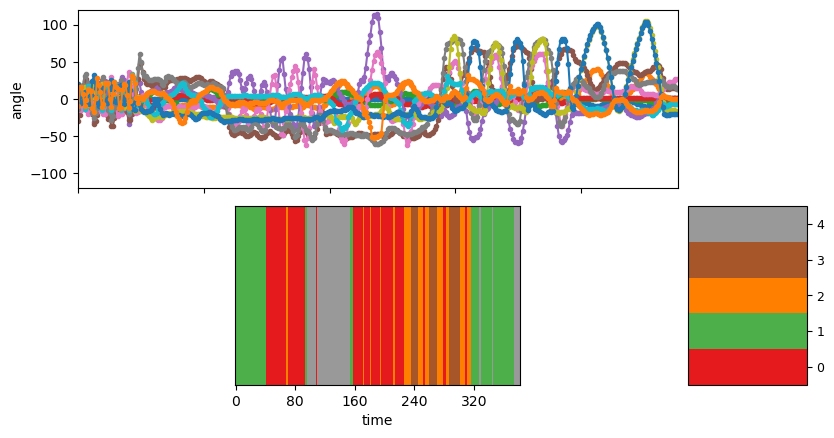

In [11]:
###############################################################################
# 
# Visualize the segmentation for sequence 0
# -----------------------------------------
#

show_single_sequence(0, zhat_T=zhat_seq0_T, K=K)

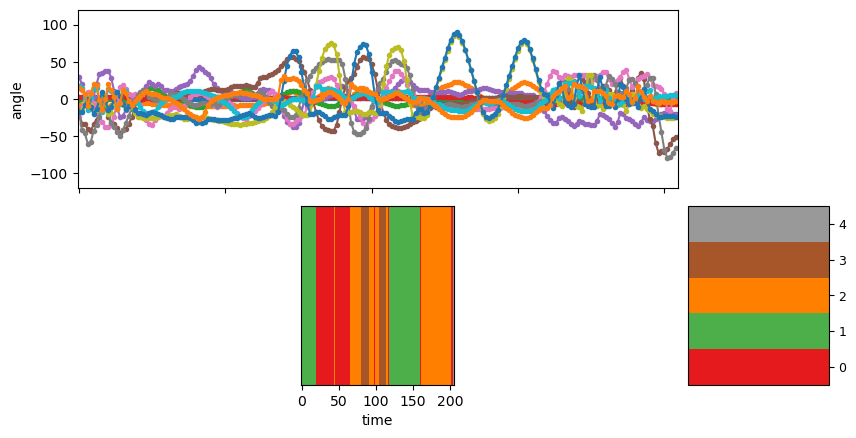

In [12]:
###############################################################################
# 
# Visualize the segmentation for sequence 1
# -----------------------------------------
#

log_lik_seq1_TK = hdphmm_trained_model.obsModel.calcLogSoftEvMatrix_FromPost(
    dataset.make_subset([1])
    )
zhat_seq1_T = bnpy.allocmodel.hmm.HMMUtil.runViterbiAlg(
    log_lik_seq1_TK, np.log(start_prob_K), np.log(trans_prob_KK))

show_single_sequence(1, zhat_T=zhat_seq1_T, K=K)


pylab.show(block=False)

In [15]:
dataset

In [24]:
import os

args = 8
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import sys
sys.path.append('/home/davcic/CP_Testing')

from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod
from fullgp import FullLatentGPModelhyper_mult
from fullgp import FullLatentGPModelhyper_mult

key = jrnd.PRNGKey(12345)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Selected GPU 8


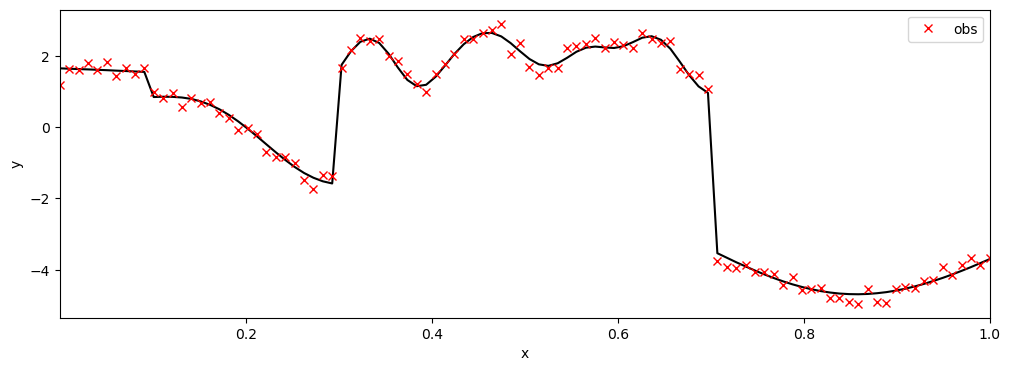

In [25]:
'''DATASET 1'''
key = jrnd.PRNGKey(1235)

f_true = jnp.load("f_true.npy")
y = jnp.load("y.npy")

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-5*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

# f_true = jnp.dot(L, z) + jnp.ones_like(z)
# key, obs_key = jrnd.split(key)
# y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

In [217]:
def show_single_sequence_new(
        seq_id,
        zhat_T=None,
        z_img_cmap=None,
        ylim=[-5, 5],
        K=5,
        left=0.2, bottom=0.2, right=0.8, top=0.95):
    if z_img_cmap is None:
        z_img_cmap = matplotlib.pyplot.get_cmap('Set1', K)

    if zhat_T is None:
        nrows = 1
    else:
        nrows = 2
    fig_h, ax_handles = pylab.subplots(
        nrows=nrows, ncols=1, sharex=True, sharey=False)
    ax_handles = np.atleast_1d(ax_handles).flatten().tolist()

    start = dataset.doc_range[seq_id]
    stop = dataset.doc_range[seq_id + 1]
    # Extract current sequence
    # as a 2D array : T x D (n_timesteps x n_dims)
    curX_TD = dataset.X[start:stop]
    for dim in range(dataset.X.shape[1]):
        ax_handles[0].plot(curX_TD[:, dim], '.-')
    ax_handles[0].set_ylabel('angle')
    ax_handles[0].set_ylim(ylim)
    z_img_height = int(np.ceil(ylim[1] - ylim[0]))
    pylab.subplots_adjust(
        wspace=0.1,
        hspace=0.1,
        left=left, right=right,
        bottom=bottom, top=top)
    if zhat_T is not None:
        img_TD = np.tile(zhat_T, (z_img_height, 1))
        ax_handles[1].imshow(
            img_TD,
            interpolation='nearest',
            vmin=-0.5, vmax=(K-1)+0.5,
            cmap=z_img_cmap)
        ax_handles[1].set_ylim(0, z_img_height)
        ax_handles[1].set_yticks([])

        # bbox = ax_handles[1].get_position()
        # width = (1.0 - bbox.x1) / 3
        # height = bbox.y1 - bbox.y0
        # cax = fig_h.add_axes([right + 0.01, bottom, width, height])
        # cbax_h = fig_h.colorbar(
        #     ax_handles[1].images[0], cax=cax, orientation='vertical')
        # cbax_h.set_ticks(np.arange(K))
        # cbax_h.set_ticklabels(np.arange(K))
        # cbax_h.ax.tick_params(labelsize=9)

    ax_handles[-1].set_xlabel('time')
    return ax_handles

In [218]:
# y = jnp.load("y.npy")
# x = np.asarray(y)
# # np.asarray(y).flags.owndata
# x.flags.owndata
orig_X = np.expand_dims(np.asarray(y[1:]), axis = 1)
prev_X = np.expand_dims(np.asarray(y[:-1]), axis = 1)
doc_range = [0, 99]
nDoc = 0

In [219]:
# dataset = bnpy.data.XData(X=orig_X, Xprev=prev_X)
# dataset.X.shape
dataset = bnpy.data.GroupXData(X=orig_X, Xprev=prev_X, doc_range=doc_range, nDoc=nDoc)


In [220]:
###############################################################################
#
# Setup: hyperparameters
# ----------------------------------------------------------

K = 50           # Number of clusters/states

# Allocation model (HDP)
gamma      =   10.0  # top-level Dirichlet concentration parameter
transAlpha =   10.5  # trans-level Dirichlet concentration parameter 
startAlpha =  10.0  # starting-state Dirichlet concentration parameter
hmmKappa   =  0.0  # set sticky self-transition weight

# Observation model (1st-order Auto-regressive Gaussian)
sF = 1.0          # Set observation model prior so E[covariance] = identity
ECovMat = 'eye'

In [221]:
hdphmm_trained_model, hmmar_info_dict = bnpy.run(
    dataset, 'HDPHMM', 'AutoRegGauss', 'memoVB',
    nLap=1, nTask=5, nBatch=1, convergeThr=0.0001,
    transAlpha=transAlpha, startAlpha=startAlpha, hmmKappa=hmmKappa,
    gamma=gamma,
    sF=sF, ECovMat=ECovMat,
    K=K, initname='randexamples',
    printEvery=25,
    )

Dataset Summary:
GroupXData
  total size: 1 units
  batch size: 1 units
  num. batches: 1
Allocation Model:  None
Obs. Data  Model:  Auto-Regressive Gaussian with full covariance.
Obs. Data  Prior:  MatrixNormal-Wishart on each mean/prec matrix pair: A, Lam
  E[ A ] = 
  [[1.]]
  E[ Sigma ] = 
  [[1.]]
Initialization:
  initname = randexamples
  K = 50 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/5 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/1
    1.000/1 after      1 sec. |   1683.0 MiB | K   50 | loss  1.658501650e+01 |  
... active. not converged.
Learn Alg: memoVB | task  2/5 | alg. seed: 6454144 | data order seed: 7673856
task_output_path: /tmp/2
    1.000/1 after      0 sec. |   1683.0 MiB | K   50 | loss  1.675206135e+01 |  
... active. not converged.
Learn Alg: memoVB | task  3/5 | alg. seed: 6168832 | data order seed: 7360256
task_output_path: /tmp/3
    1.000/1 after      1 sec. |   1683.1 MiB | K   50 | 

[<Axes: ylabel='angle'>, <Axes: xlabel='time'>]

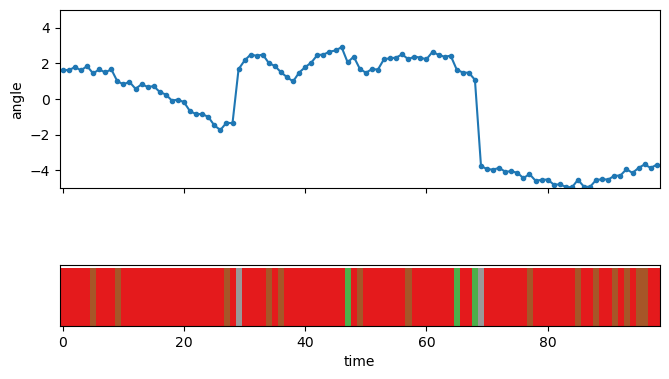

: 

In [222]:
start_prob_K = hdphmm_trained_model.allocModel.get_init_prob_vector()

# print(start_prob_K)

trans_prob_KK = hdphmm_trained_model.allocModel.get_trans_prob_matrix()

# print(trans_prob_KK)

log_lik_seq0_TK = hdphmm_trained_model.obsModel.calcLogSoftEvMatrix_FromPost(
    dataset.make_subset([0])
    )

# print(log_lik_seq0_TK[:10, :])

zhat_seq0_T = bnpy.allocmodel.hmm.HMMUtil.runViterbiAlg(
    log_lik_seq0_TK, np.log(start_prob_K), np.log(trans_prob_KK))

# print(zhat_seq0_T[:10])

show_single_sequence_new(0, zhat_T=zhat_seq0_T, K=K)

In [153]:
# hdphmm_trained_model.obsModel.EstParams
hasattr(hdphmm_trained_model.obsModel, 'Post')

hdphmm_trained_model.obsModel.setEstParamsFromPost(hdphmm_trained_model.obsModel.Post)

hdphmm_trained_model.obsModel.EstParams.Sigma

hdphmm_trained_model.obsModel.EstParams.A
log_lik_seq0_TK = hdphmm_trained_model.obsModel.calcLogSoftEvMatrix_FromPost(
    dataset.make_subset([0])
    )

# print(log_lik_seq0_TK)

print(np.sum(jnp.max(log_lik_seq0_TK, axis = 1)))
# jnp.max(log_lik_seq0_TK, axis = 1)

-22.705807810669473


### IHMM Likelihood

-22.77114505890699


## GP

In [109]:
size = 10
T = 1
max_CP = size
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params_hyper(base_kernel)

priors = dict(kernel=dict(
                          # lengthscale=Uniform_mod(low = jnp.zeros(max_CP+1),
                          #                        high = jnp.zeros(max_CP+1)+1),
                          # variance=Uniform_mod(low = jnp.zeros(max_CP+1),
                          #                        high = jnp.zeros(max_CP+1)+5),
                          lengthscale=LogNormal_mod(0, 2, max_CP+1),
                          variance=LogNormal_mod(0.5, 1, max_CP+1), 
                        #   lengthscale=dx.Transformed(dx.MultivariateNormalFullCovariance(jnp.zeros(max_CP),
                        #                                                                  jnp.eye(max_CP)), 
                        #                              dx.Block(tfb.Exp(), 1)),
                        #   variance=dx.Transformed(dx.MultivariateNormalFullCovariance(jnp.zeros(max_CP),
                        #                                                               jnp.eye(max_CP)),
                        #                           dx.Block(tfb.Exp(), 1)),
                          num=Poisson_Process_hyper(size, T)
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())),
              hyper = dict(hyper_pp = dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp())))

gp_marginal = FullMarginalGPModelhyper_mult(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

In [110]:
%%time
num_particles = 1000
num_mcmc_steps = 100
key, gpm_key = jrnd.split(key)
mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps),
                                                                  poisson = True)

No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
CPU times: user 2min 45s, sys: 1.03 s, total: 2min 46s
Wall time: 2min 44s


Text(0, 0.5, 'Marginal GP')

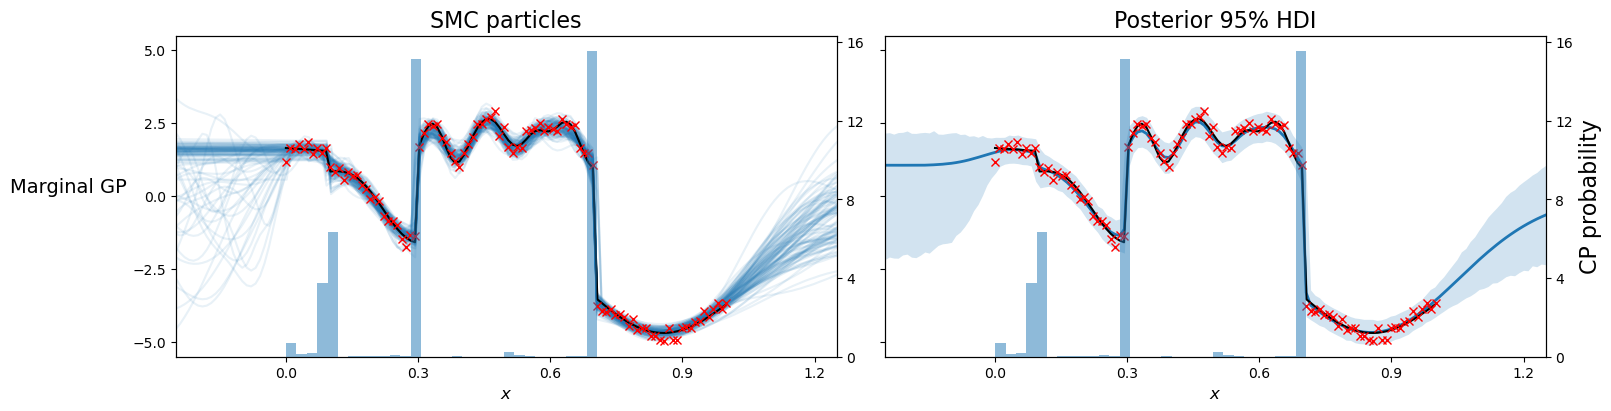

In [111]:
x_pred = jnp.linspace(-0.25, 1.25, num=150)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                            sharey=True, constrained_layout=True)


key, key_pred = jrnd.split(key)
f_pred = gp_marginal.predict_f(key_pred, x_pred)

pd = mgp_particles.particles['kernel']['num']
# There are some outliers that skew the axis
# pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
# pd_filtered = jnp.extract(pd>pd_l, pd)
# pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1]
f_mean = jnp.mean(f_pred, axis=0)
y_pred = gp_marginal.predict_y(key_pred, x_pred)
f_hdi_lower = jnp.percentile(y_pred, q=2.5, axis=0)
f_hdi_upper = jnp.percentile(y_pred, q=97.5, axis=0)
# f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
# f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right', fontsize=14)

In [118]:
mu = f_mean[25:125]
# cov = jnp.eye(100)*jnp.mean(mgp_particles.particles['likelihood']['obs_noise'])
cov = jnp.zeros(100)+jnp.mean(mgp_particles.particles['likelihood']['obs_noise'])
MVN = dx.MultivariateNormalDiag(mu, cov)
print(MVN.log_prob(y))

sigma = jnp.mean(mgp_particles.particles['likelihood']['obs_noise'])
log_prob = 0
for i, y_i in enumerate(y):
    N = dx.Normal(mu[i], sigma)
    log_prob += N.log_prob(y_i)

print(log_prob)

26.881574132809135
26.881574132809156
